# Tutorial: Discrete Dynamic Programming

## Computational Economics

## Markov Chains

A worker’s employment dynamics obey the stochastic matrix

$$P = \begin{bmatrix}
1-\alpha & \alpha \\
\beta & 1-\beta
\end{bmatrix}$$




with $\alpha\in(0,1)$ and $\beta\in (0,1)$. First line corresponds to employment, second line to unemployment.

__Which is the stationary equilibrium?__

In [1]:
using LinearAlgebra: I, \

In [2]:
α = 0.05
β = 0.1

0.1

In [3]:
P = [1-α α ; β 1-β]

2×2 Matrix{Float64}:
 0.95  0.05
 0.1   0.9

We want to find $\mu$ such that $\mu' P = \mu'$ or equivalently $\mu = P' \mu$ and $|\mu|=1$

It should satisfy $\underbrace{(P' - I)}_{M}\mu = 0$ and $|\mu|=1$.

In [4]:
M = P' - I

2×2 Matrix{Float64}:
 -0.05   0.1
  0.05  -0.1

We can see two lines of $M$ are colinear. We replace the latest one with ones to get $\tilde{M}$ and solve $\tilde{M} \mu = \begin{matrix} 0 \\1\end{matrix}$

In [5]:
Mt = copy(M)
Mt[end, :] .= 1
Mt

2×2 Matrix{Float64}:
 -0.05  0.1
  1.0   1.0

In [6]:
rhs = [0, 1]

2-element Vector{Int64}:
 0
 1

In [7]:
μ = Mt\ rhs

2-element Vector{Float64}:
 0.6666666666666665
 0.33333333333333354

Check the solution:

In [8]:
sum(μ) # should be 1

1.0

In [9]:
μ' * P - μ'  # should be 0 0

1×2 adjoint(::Vector{Float64}) with eltype Float64:
 0.0  0.0

__In the long run, what will the the fraction $p$ of time spent unemployed? (Denote by $X_m$ the fraction of dates were one is unemployed)__

In [10]:
# the mathematical result is $\mu$ because it is the ergodic distribution. Let's check it numerically.

__Illustrate this convergence by generating a simulated series of length 10000 starting at $X_0=1$. Plot $X_m-p$ against $m$. (Take $\alpha=\beta=0.1$).__

In [11]:
s0 = 1

1

In [12]:
function simulate(P, i0; T=10000)
    # i0 : index of initial state
    sim = []
    for t=1:T
        push!(sim, i0)
        p = P[i0,:]
        # you want to draw 1 with probability p[1] and 2 with probability p[2]=1-p[1]
        u = rand()
        if u<=p[1]
            i0 = 1
        else
            i0 = 2
        end
    end
    return sim
end

simulate (generic function with 1 method)

In [13]:
sim = simulate(P, 1);


In [14]:
using Plots

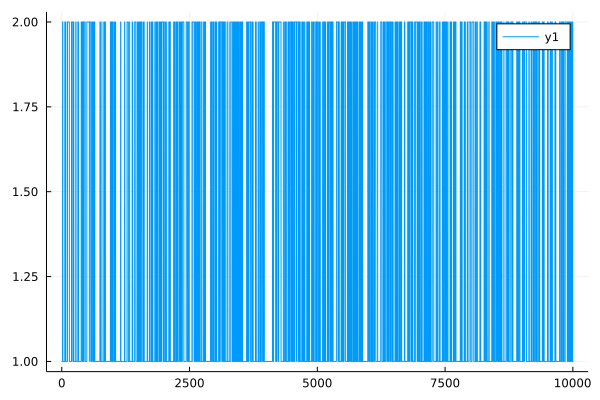

In [15]:
plot(sim)

In [16]:
methods(count_ones)

# 2 methods for generic function "count_ones":
[1] count_ones(x::Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8}) in Base at int.jl:404
[2] count_ones(x::BigInt) in Base.GMP at gmp.jl:558

In [17]:
fun1(sim) = sum(1 .- (sim .- 1)) # number of periods employed

fun1 (generic function with 1 method)

In [18]:
fun2(sim) = count(u->u==1, sim)

fun2 (generic function with 1 method)

In [19]:
@time fun1(sim)

  0.274359 seconds (378.35 k allocations: 20.389 MiB, 6.25% gc time, 99.41% compilation time)


6712

In [20]:
@time fun2(sim)

  0.046773 seconds (11.06 k allocations: 623.393 KiB, 99.25% compilation time)


6712

In [21]:
count(u->u==1, sim) / length(sim) # close to 0.66

0.6712

In [22]:
proportions = [count(u->u==1, sim[1:m]) / length(sim[1:m]) for m=1:length(sim)];

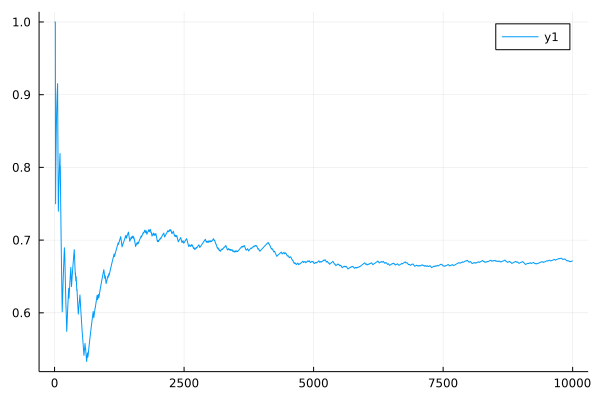

In [23]:
plot(proportions)

## Asset replacement (from Compecon)

At the beginning of each year, a manufacturer must decide whether to continue to operate an aging physical asset or replace it with a new one.

An asset that is $a$ years old yields a profit contribution $p(a)$ up to $n$ years, at which point, the asset becomes unsafe and must be replaced by law.

The cost of a new asset is $c$. What replacement policy maximizes profits?

Calibration: profit $p(a)=50-2.5a-2.5a^2$. Maximum asset age: 5 years. Asset replacement cost: 75, annual discount factor $\delta=0.9$.

__Define a structure holding the parameters. Plot the profit function.__

In [47]:
param = (n=5, c=75, δ=0.9)

(n = 5, c = 75, δ = 0.9)

In [25]:
p(a) = 50 - 2.5a - 2.5a^2

p (generic function with 1 method)

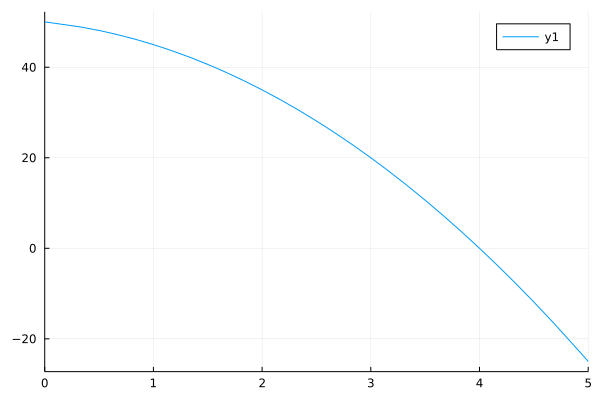

In [41]:
plot(p, xlims=(0,5))

__Define kind of problem, the state space, the actions, the reward function, and the Bellman updating equation__

This is a problem with discrete states (years between 0 and 5), discrete states (replace or keep current asset) and infinite time. The objective is to maximize:
$$
V(a) = \sum_{t=0}^\infty \delta^t P_t
$$

We hence have the following Bellman equation:
$$
V(a) = \max_{r \in \{0,1\}} \; p(a) + \delta \begin{cases} V(a+1) \quad \text{if} \; r = 0\\ V(0) - 75 \quad \text{if} \; r = 1 \end{cases}
$$

__Solve the problem using Value Function Iteration__

In [74]:
V0 = p.(range(0,5))

6-element Vector{Float64}:
  50.0
  45.0
  35.0
  20.0
   0.0
 -25.0

In [75]:
function value_update(V0, param)
    V1 = V0*0
    for (i,a) in enumerate(range(0, param.n))
        π = p(a)

        V_nr = a==param.n ? V_nr = -Inf : V0[i+1]
        V_r = V0[1] - param.c
        r = V_r > V_nr ? true : false

        if r
            V1[i] = π + param.δ * V_r
        else
            V1[i] = π + param.δ * V_nr
        end
    end
    return V1
end

value_update (generic function with 1 method)

In [76]:
value_update(V0, param)

6-element Vector{Float64}:
  90.5
  76.5
  53.0
  20.0
 -22.5
 -47.5

In [77]:
function vfi(param; T=1000, τ_η = 1e-8)
    V0 = p.(range(0,param.n))
    for t=1:T
        V1 = value_update(V0, param)
        η = maximum(abs, V1-V0)
        if η < τ_η
            break
        end
        V0 = V1
    end
    return V0
end

vfi (generic function with 1 method)

In [78]:
V = vfi(param)

6-element Vector{Float64}:
 244.90404179652333
 216.56004645139782
 190.62227384480133
 172.91363761459246
 152.91363761459246
 127.91363761459246

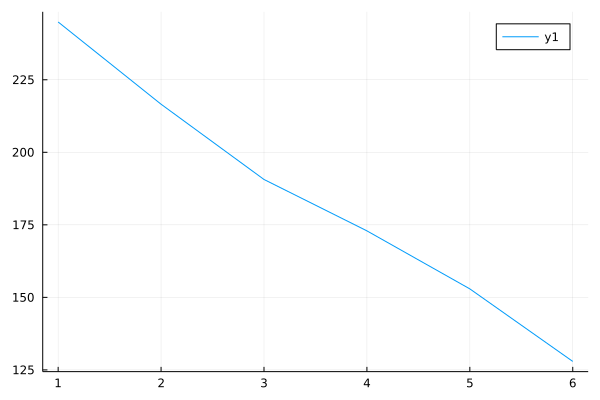

In [79]:
plot(V)

__Solve the problem using Policy Iteration. Compare with VFI.__

In [80]:
function policy_iteration_step(V0, r0, param)
    V1 = V0*0
    for (i,a) in enumerate(range(0, param.n))
        π = p(a)

        V_nr = a==param.n ? V_nr = -Inf : V0[i+1]
        V_r = V0[1] - param.c
        r = r0[i]

        if r
            V1[i] = π + param.δ * V_r
        else
            V1[i] = π + param.δ * V_nr
        end
    end
    return V1
end

policy_iteration_step (generic function with 1 method)

In [81]:
function policy_iteration(r0, param; T=1000, τ_η = 1e-8)
    V0 = p.(range(0,param.n))
    for t=1:T
        V1 = policy_iteration_step(V0, r0, param)
        η = maximum(abs, V1-V0)
        if η < τ_η
            break
        end
        V0 = V1
    end
    return V0
end

policy_iteration (generic function with 1 method)

In [82]:
r0 = [false, false, true, true, true, true]

6-element Vector{Bool}:
 0
 0
 1
 1
 1
 1

In [83]:
policy_iteration(r0, param)

6-element Vector{Float64}:
 236.80811803522695
 207.56457560576638
 180.62730623723914
 165.62730623723914
 145.62730623723914
 120.62730623723914

### Job-Search Model

- When unemployed in date, a job-seeker
  - consumes unemployment benefit $c_t = \underline{c}$
  - receives in every date $t$ a job offer $w_t$
    - $w_t$ is i.i.d., 
    - takes values $w_1, w_2, w_3$ with probabilities $p_1, p_2, p_3$
  - if job-seeker accepts, becomes employed at rate $w_t$ in the next period
  - else he stays unemployed
  
- When employed at rate $w$
  - worker consumes salary $c_t = w$
  - with small probability $\lambda>0$ looses his job:
    - starts next period unemployed
  - otherwise stays employed at same rate
- Objective: $\max E_0 \left\{ \sum \beta^t \log(w_t) \right\}$


__What are the states, the controls, the reward of this problem ? Write down the Bellman equation.__

__Define a parameter structure for the model.__

In [84]:
param2 = (β=0.9, w=[0.9, 1, 1.1], p=[1/3, 1/3, 1/3], cbar=0.5, λ=0.05)

(β = 0.9, w = [0.9, 1.0, 1.1], p = [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], cbar = 0.5, λ = 0.05)

__Define a function  `value_update(V_U::Vector{Float64}, V_E::Vector{Float64}, x::Vector{Bool}, p::Parameters)::Tuple{Vector, Vector}`, which takes in value functions tomorrow and a policy vector and return updated values for today.__

In [98]:
function value_update_2(V_U::Vector{Float64}, V_E::Vector{Float64}, x::Vector{Bool}, param2)::Tuple{Vector, Vector}
    n = length(param2.w)
    n_V_U = V_U*0
    n_V_E = V_E*0

    for i=1:n
        n_V_U[i] = log(param2.cbar) + param2.β*(x[i] ? V_E[i] : V_U[i])
    end

    for i=1:n
        w = param2.w[i]
        n_V_E[i] = log(w) + param2.β*(1 - param2.λ)*V_E[i] + param2.β*sum(param2.p[j]*V_U[j] for j=1:n)
    end
    
    return (n_V_U, n_V_E)
end

value_update_2 (generic function with 1 method)

In [99]:
V_U_0 = V_E_0 = zeros(length(param2.p))
x_0 = zeros(Bool, length(param2.p))

3-element Vector{Bool}:
 0
 0
 0

In [100]:
value_update_2(V_U_0, V_E_0, x_0, param2)

([-0.6931471805599453, -0.6931471805599453, -0.6931471805599453], [-0.10536051565782628, 0.0, 0.09531017980432493])

__Define a function `policy_eval(x::Vector{Bool}, p::Parameter)::Tuple{Vector, Vector}` which takes in a policy vector and returns the value(s) of following this policies forever. You can add relevant arguments to the function.__ which takes in a policy vector and returns the value(s) of following this policies forever. You can add relevant arguments to the function.__

In [101]:
function policy_eval_2(x::Vector{Bool}, param2; T=1000)::Tuple{Vector, Vector}
    V_U_0 = V_E_0 = zeros(length(param2.p))
    for t=1:T
        V_U_1, V_E_1 = value_update_2(V_U_0, V_E_0, x, param2)
        V_U_0, V_E_0 = V_U_1, V_E_1
    end
    return V_U_0, V_E_0
end

policy_eval_2 (generic function with 1 method)

In [102]:
policy_eval_2([false, false, false], param2)

([-6.931471805599451, -6.931471805599451, -6.931471805599451], [-43.749552694464334, -43.02292844854827, -42.36561686369088])

__Define a function `bellman_step(V_E::Vector, V_U::Vector, p::Parameters)::Tuple{Vector, Vector, Vector}` which returns updated values, together with improved policy rules.__

In [33]:
function bellman_step(V_E::Vector, V_U::Vector, param2)::Tuple{Vector, Vector, Vector}
    n = length(param2.w)
    n_V_U = V_U*0
    n_V_E = V_E*0
    x = zeros(Bool, n)
    
    
end

__Implement Value Function__

In [34]:
function vfi_2(param2; T=1000, τ_η = 1e-8)
    V_U_0 = V_E_0 = zeros(length(param2.p))
    local x

    for t=1:T
        V_U_1, V_E_1, x = bellman_step(V_U_0, V_E_0, param2)
        η = maximum(abs, V1-V0)
        if η < τ_η
            break
        end
        V0 = V1
    end
    return V_U_0, V_E_0, x
end

__Implement Policy Iteration and compare rates of convergence.__

__Discuss the Effects of the Parameters__